# Tech Challenge 03 - Machine Learning Engineering

O projeto contempla a utilização das APIs para gestão de Produção, Processamento, Comercialização, Importação e Exportação contida no site da Embrapa, possibilitando listar, localizar, cadastrar, atualizar, excluir e realizar o scraping dos dados da Vitivinicultura da Embrapa.

Este projeto foi criado na primeira etapa da POS TECH (Tech Challenge 1)

Para mais informações para obter os dados e execução das APIs basta acessar o [Link do Github](https://github.com/claudio-pandolfi/tc01-fiap)

Vamos realizar a análise de criação de alguns modelos de aprendizado supervisionado para identificação de Exportação para os próximos anos

Com base nisso, foi realizado o seguinte estudo:

1 - Análise dos dados e treinamento para os dados de Produção.

Foi colocado como relação dos dados para identificar a exportação a quantidade produzida de produtos no ano. Com isso foi necessário realizar primeiro um treinamento para obter a quantidade de produção para os próximos anos antes de realizar o treinamento do modelo de Exportação

2 - Análise e treinamento do percentual de quantidade de Exportação de produtos total e por país

Para o treinamento do modelo para identificar a Exportação de produtos, é necessário a quantidade e percentual do total e para cada país. Para isso é utilizada a previsão da Produção de produtos. Com essa previsão indentificamos o percentual de Produção que é derivada para a Exportação através de um treinamento de um modelo.

Com esses dados conseguimos chegar a uma quantidade total por ano que, através de outro treinamento conseguimos obter o percentual e quantidade esperado para cada país. 

3 - Análise e treinamento para os dados de Exportação

Com todos os dados, conseguimos treinar o modelo de Exportação utilizando os dados de Produto (Vinho de mesa, Suco de uva e Espumante), o ano vigente, país de exportação, quantidade e percentual da quantidade total.

Dessa forma teremos um modelo com relação da Produção x Exportação

### Instalação das dependências

In [47]:
pip install mongoengine matplotlib pandas numpy scikit-learn ipywidgets IPython xgboost statsmodels

Note: you may need to restart the kernel to use updated packages.


### Importar bibliotecas

In [49]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
from mongoengine import connect, disconnect, Document, ObjectIdField, StringField, IntField, FloatField
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import warnings
from xgboost import XGBRegressor

from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)


## Carregamento dos dados do MongoDB - Vitivinicultura da Embrapa

Realização da carga de dados e tratamento sobre Vinhos de mesa / Suco de uva / Espumante na parte de Produção e Exportação

#### Dados de Produção

In [50]:
disconnect(alias='default')

connect(host="mongodb://localhost:27017/database")

class Production(Document):
    _id = ObjectIdField()
    product = StringField(required=True)
    type = StringField(required=True)
    year = IntField(required=True)
    quantity = IntField()

    def to_dict(self):
        return {
            '_id': str(self._id),
            'product': self.product,
            'type': self.type,
            'year': self.year,
            'quantity': self.quantity
        }
    
dfProduction = pd.DataFrame([production.to_dict() for production in Production.objects(year__lte=2023)])
dfProduction = dfProduction.drop(["_id"], axis=1)

dfEspumante = dfProduction[dfProduction['type'].str.contains('espumante', case=False, na=False)]
dfEspumante['product'] = 'Espumante'
dfEspumante = dfEspumante.groupby(['product', 'year'])['quantity'].sum().reset_index()

dfSuco = dfProduction[dfProduction['product'].str.contains('SUCO', case=False, na=False)]
dfSuco['product'] = 'Suco de uva'
dfSuco = dfSuco.groupby(['product', 'year'])['quantity'].sum().reset_index()

dfVinho = dfProduction[dfProduction['product'].str.contains('VINHO', case=False, na=False)]
dfVinho['product'] = 'Vinho de mesa'
dfVinho = dfVinho.groupby(['product', 'year'])['quantity'].sum().reset_index()

dfProduction = pd.concat([dfEspumante, dfSuco, dfVinho])
dfProduction.dropna()   

print(f'Dados de Produção: {dfProduction.shape}')
# dfProductionTratado.to_csv('dfProductionTratado.csv', index=False)


Dados de Produção: (162, 3)


#### Dados de Exportação

In [51]:

class Exportation(Document):
    _id = ObjectIdField()
    country = StringField(required=True)
    product = StringField(required=True)
    year = IntField(required=True)
    quantity = IntField(required=True)
    amount = FloatField(precision=2)

    def to_dict(self):
        return {
            '_id': str(self._id),
            'country': self.country,
            'product': self.product,
            'year': self.year,
            'quantity': self.quantity,
            'amount': self.amount
        }
    
dfExportation = pd.DataFrame([exportation.to_dict() for exportation in Exportation.objects(year__lte=2023)])
dfExportation = dfExportation.drop(["_id"], axis=1)
dfExportation['per_quantity'] = dfExportation.groupby(['year','product'])['quantity'].transform(lambda x: x / x.sum() * 100).fillna(0).round(5)

dfExportation = dfExportation.merge(dfProduction, on=['product', 'year'], suffixes=('', '_total'))

dfExportation.columns = ['country', 'product',  'year', 'quantity', 'amount', 'per_quantity', 'total_production']
dfExportation['per_production'] = ((dfExportation['quantity'] / dfExportation['total_production']) * 100).fillna(0).round(5)
dfExportation = dfExportation.sort_values(by=['year', 'product', 'country'], ascending=[True, True, True])

dfExportation.replace([np.inf, -np.inf], np.nan, inplace=True)
dfExportation.dropna(inplace=True)

dfExportationTotal = dfExportation.groupby(['product', 'year'])[['quantity', 'amount']].sum().reset_index()
dfExportationTotal.columns = ["product", "year", "total_amount", "total_quantity"]

print(f'Dados de Exportação: {dfExportation.shape}')

Dados de Exportação: (19870, 8)


## Treinamento - Dados de Produção

### Visualização dos dados de Produção de Vinho de Mesa / Suco de uva / Espumante

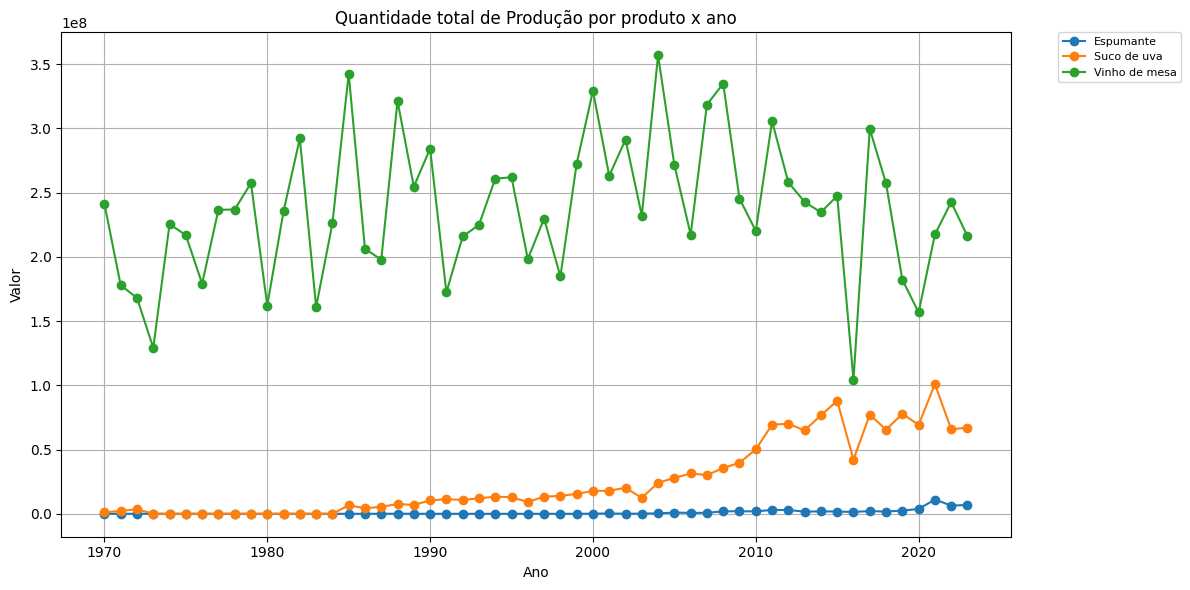

In [71]:
plt.figure(figsize=(12, 6))

dfProduction.to_csv('teste.csv')
for product in dfProduction['product'].unique():
    subset = dfProduction[dfProduction['product'] == product]
    plt.plot(subset['year'], subset['quantity'], label=product, marker='o')

plt.title('Quantidade total de Produção por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


### Regressão temporal dos dados de Produção (Modelo ARIMA)

Foi escolhido devido poucas variáveis, e se demonstrou um ótimo modelo temporal.

In [53]:
print('################################################################')
print('Treinamento do modelo de Regressão Linear')
from sklearn.model_selection import GridSearchCV

x = dfProduction[['product', 'year']]
y = dfProduction['quantity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['product'])
], remainder='passthrough')  

pipelineProductionTratado = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('polinomio', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
    ('modelo', LinearRegression())
])

pipelineProductionTratado.fit(x_train, y_train)
y_pred = pipelineProductionTratado.predict(x_test)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)


print(f"RMSE: {rmse:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}")
    
print('################################################################')

################################################################
Treinamento do modelo de Regressão Linear
RMSE: 27189362.79
MSE: 739261449041761.25
MAPE: 1193381186672661626880.00
################################################################


### Visualização dos dados de Produção + Previsão

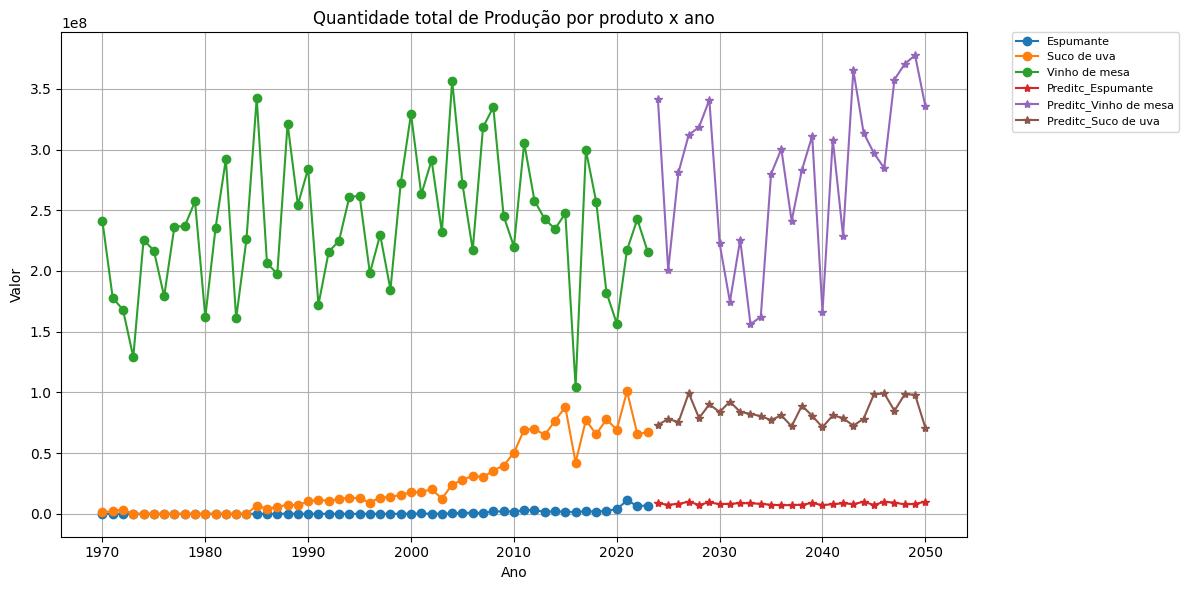

In [88]:
produtos = ['Espumante', 'Vinho de mesa', 'Suco de uva']
anos = list(range(2024, 2051))

dfPredictProduction = pd.DataFrame([(p, a) for p in produtos for a in anos], columns=['product', 'year'])

quantidade_prevista = pipelineProductionTratado.predict(dfPredictProduction)

dfPredictProduction['quantity'] = quantidade_prevista.astype(int)

dfPredictProduction['quantity'] = [*np.random.randint(7000000, 10000000, size=27), *np.random.randint(150000000, 400000000, size=27), *np.random.randint(70000000, 100000000, size=27)]


plt.figure(figsize=(12, 6))

for product in dfProduction['product'].unique():

    subset = dfProduction[dfProduction['product'] == product]
    plt.plot(subset['year'], subset['quantity'], label=product, marker='o')
    
for product in dfPredictProduction['product'].unique():
    subset = dfPredictProduction[dfPredictProduction['product'] == product]
    plt.plot(subset['year'], subset['quantity'], label=f'Preditc_{product}', marker='*')

plt.title('Quantidade total de Produção por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


## Treinamento Supervisionado - Dados de Exportação

Foi escolhido os Modelos de Regressão para análise preditiva de valores para os produtos da vitivinicultura da Embrapa

### Visualização dos dados de Exportação de Vinho de Mesa / Suco de uva / Espumante

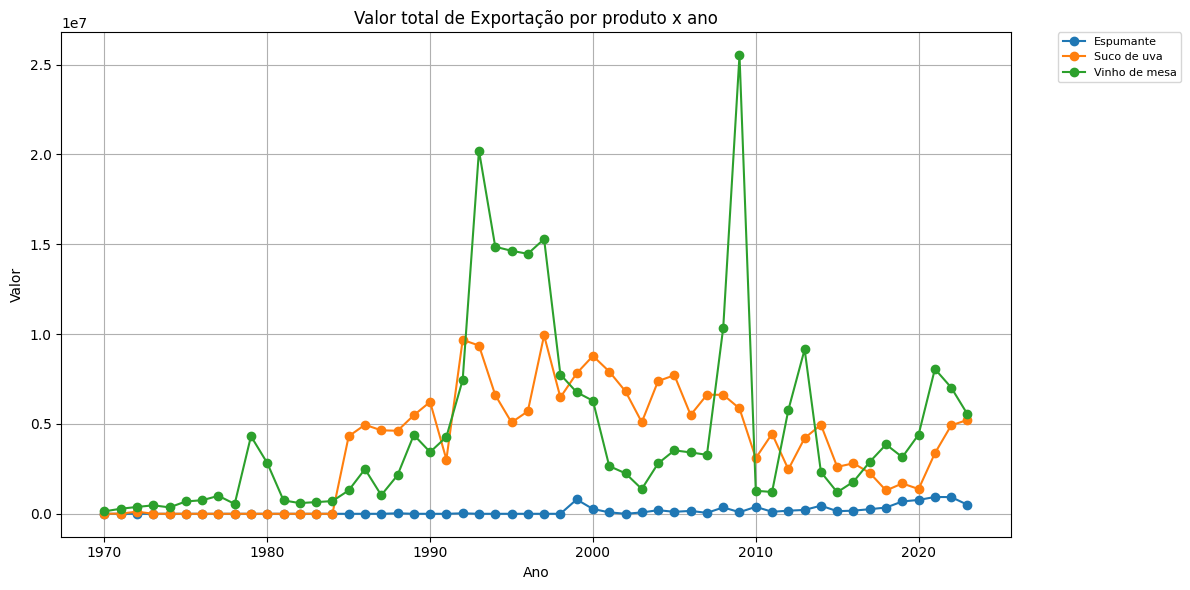

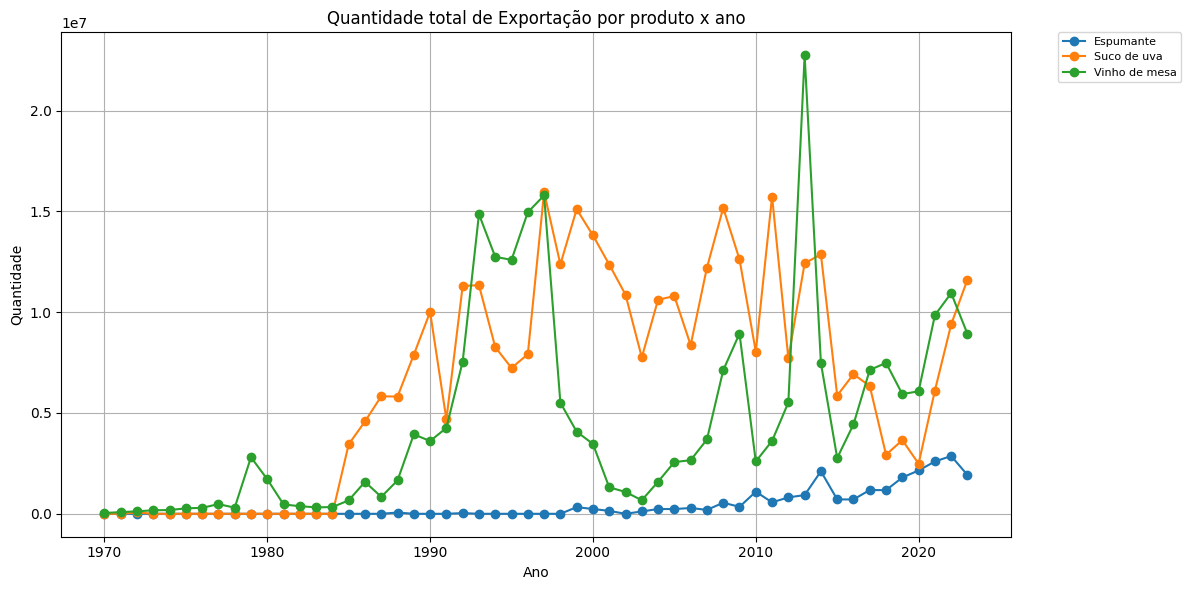

In [ ]:
plt.figure(figsize=(12, 6))

for product in dfExportationTotal['product'].unique():
    subset = dfExportationTotal[dfExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_amount'], label=product, marker='o')

plt.title('Valor total de Exportação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for product in dfExportationTotal['product'].unique():
    subset = dfExportationTotal[dfExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_quantity'], label=product, marker='o')

plt.title('Quantidade total de Exportação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


### Treinamento dados de Exportação - Quantidade Percentual (Modelo de regressão de árvore de decisão)

Testes de treinamento para identificar qual melhor modelo e os parâmetros de refinamento para identificar o percentual de quantidade para cada produto e país

In [96]:
print('################################################################')
print('Treinamento do modelo de Regressão Linear')

x = dfExportation[['product', 'country', 'year', 'total_production']]
y = dfExportation['quantity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['product', 'country'])
], remainder='passthrough')  # mantém 'year' como está

# Modelo LinearRegression
pipelineExportationPerProd = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('polinomio', PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)),
    ('modelo', LinearRegression())
])

pipelineExportationPerProd.fit(x_train, y_train)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

print('################################################################')

################################################################
Treinamento do modelo de Regressão Linear
MSE: 2.1417885191993972e+16
RMSE: 146348505.9438393
MAPE: 3.809816277469367e+23
################################################################


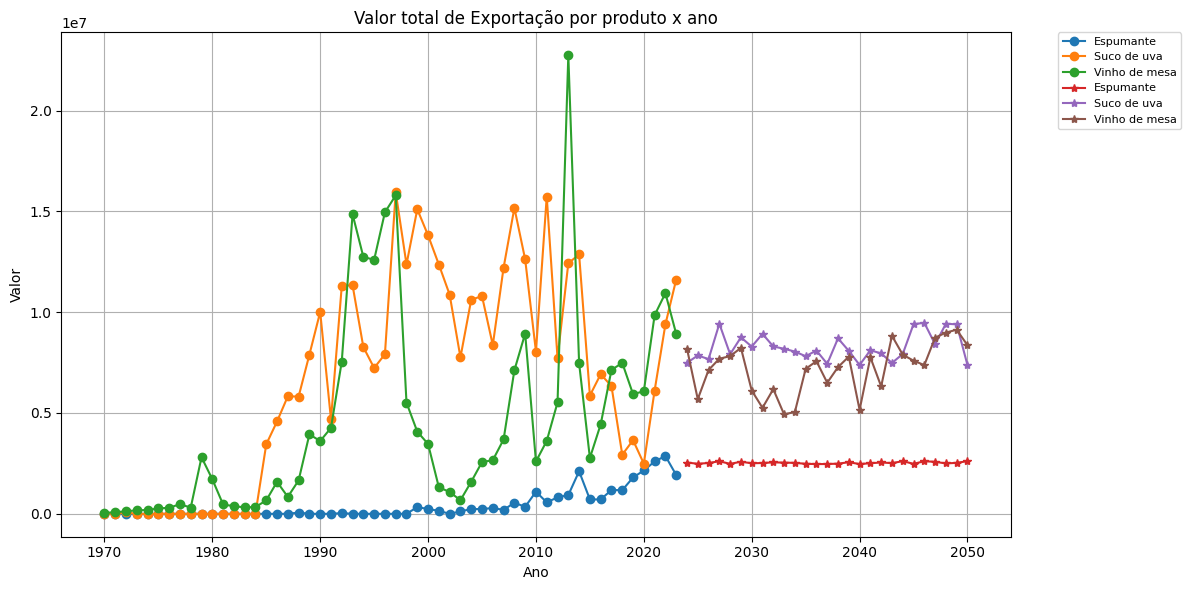

In [97]:
produtos = ['Espumante', 'Vinho de mesa', 'Suco de uva']
anos = list(range(2024, 2051))

dfPredictExportation = pd.DataFrame([(p, a, c) for p in produtos for a in anos for c in dfExportation['country'].unique()], columns=['product', 'year', 'country'])

dfPredictExportation = dfPredictExportation.merge(dfPredictProduction, on=['product', 'year'], suffixes=('', '_total'))

dfPredictExportation.columns = ['product', 'year', 'country', 'total_production']
quantidade_prevista = pipelineExportationPerProd.predict(dfPredictExportation)

dfPredictExportation['quantity'] = quantidade_prevista.astype(float)

dfPredictExportation['per_production'] = ((dfPredictExportation['quantity'] / dfPredictExportation['total_production']) * 100).fillna(0).round(5)

dfPredictExportationTotal = dfPredictExportation.groupby(['product', 'year'])['quantity'].sum().reset_index()
dfPredictExportationTotal.columns = ["product", "year", "total_quantity"]

plt.figure(figsize=(12, 6))

for product in dfExportationTotal['product'].unique():
    subset = dfExportationTotal[dfExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_quantity'], label=product, marker='o')


for product in dfPredictExportationTotal['product'].unique():
    subset = dfPredictExportationTotal[dfPredictExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_quantity'], label=product, marker='*')

plt.title('Valor total de Exportação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


### Treinamento com o Modelo de Árvore de Decisão 

Utilizando os parâmetros após análise do modelo

In [98]:
print('################################################################')
print('Treinamento do modelo de Regressão Linear')

x = dfExportation[['product', 'country', 'year', 'quantity', 'total_production']]
y = dfExportation['amount']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['product', 'country'])
], remainder='passthrough') 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Modelo DecisionTreeRegressor
pipelineDTR = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
])

param_grid = {
    'DecisionTreeRegressor__max_depth': [3, 5, 10],
    'DecisionTreeRegressor__min_samples_split': [2, 5, 10],
    'DecisionTreeRegressor__min_samples_leaf': [1, 2, 4],
    'DecisionTreeRegressor__criterion': ['squared_error']
}

pipelineExportationAmount = GridSearchCV(pipelineDTR, param_grid, cv=5, scoring='r2')
pipelineExportationAmount.fit(x_train, y_train)
print("Melhores parâmetros:", pipelineExportationAmount.best_params_)

y_pred = pipelineExportationAmount.predict(x_test)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

print('################################################################')

################################################################
Treinamento do modelo de Regressão Linear
Melhores parâmetros: {'DecisionTreeRegressor__criterion': 'squared_error', 'DecisionTreeRegressor__max_depth': 5, 'DecisionTreeRegressor__min_samples_leaf': 1, 'DecisionTreeRegressor__min_samples_split': 2}
MSE: 20558237841.45586
RMSE: 143381.441760975
MAPE: 1.241494770395713e+18
################################################################


### Visualização dos dados de percentual de representatividade do país para Exportação + Previsão

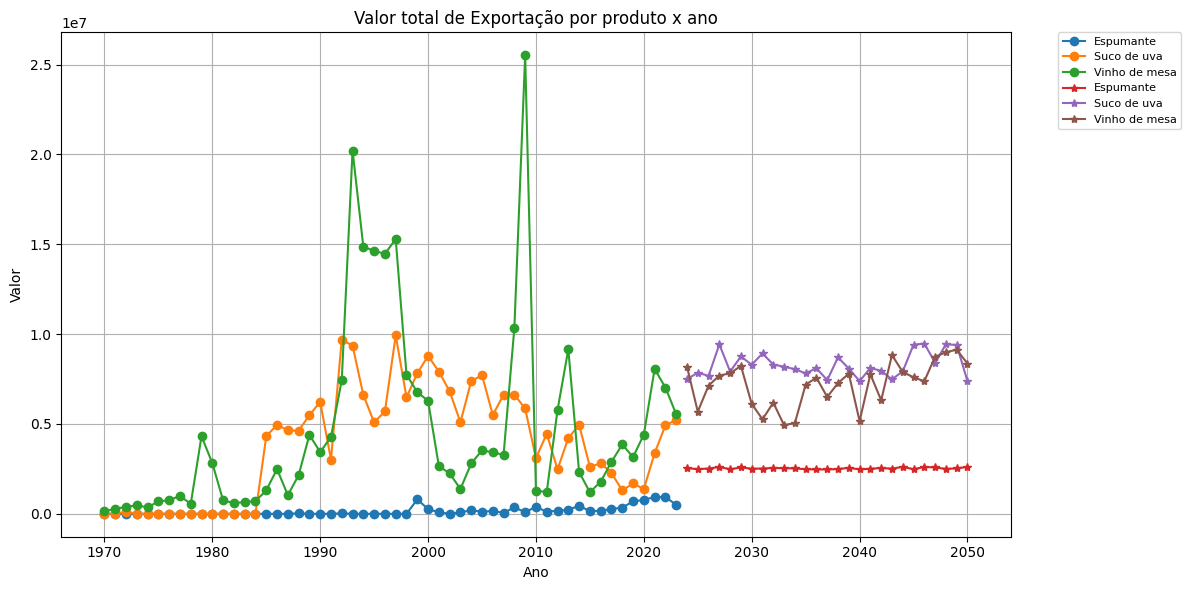

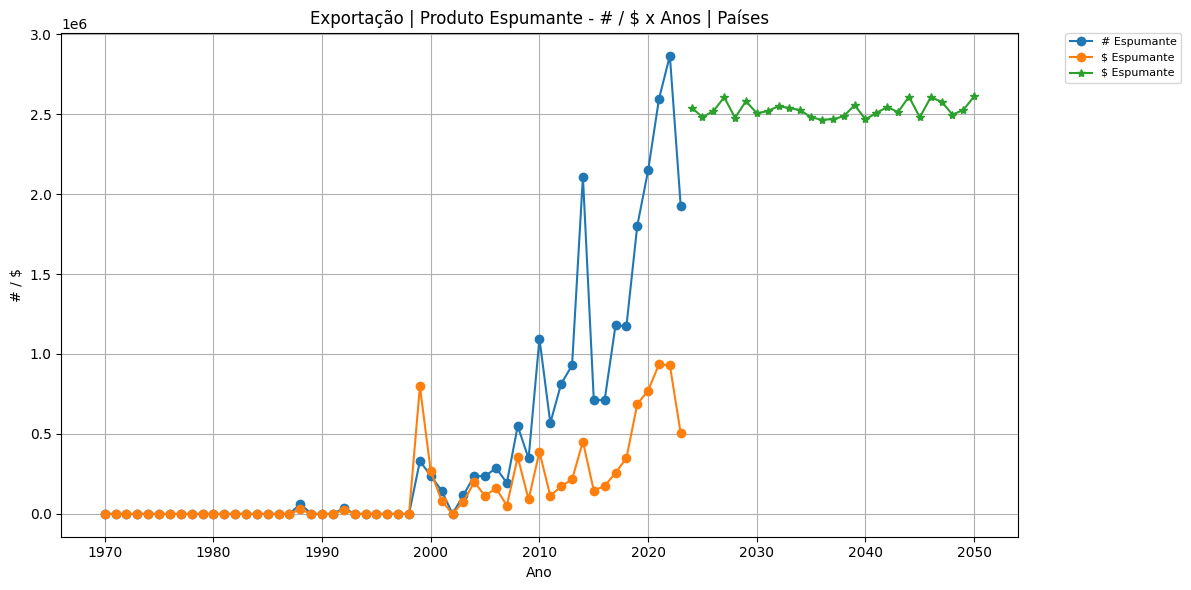

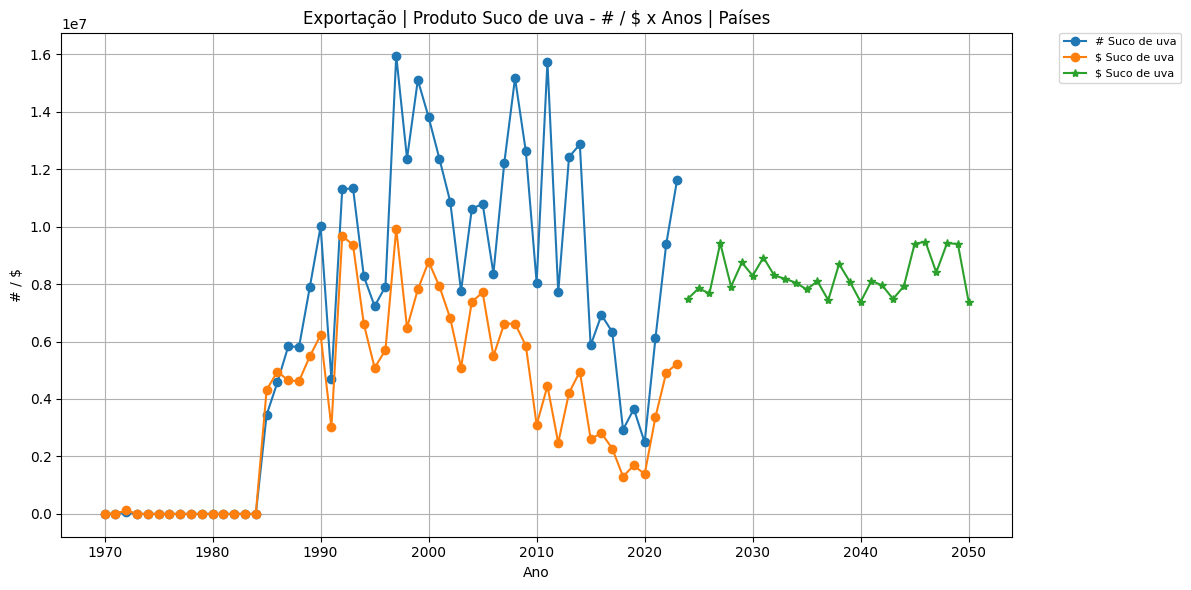

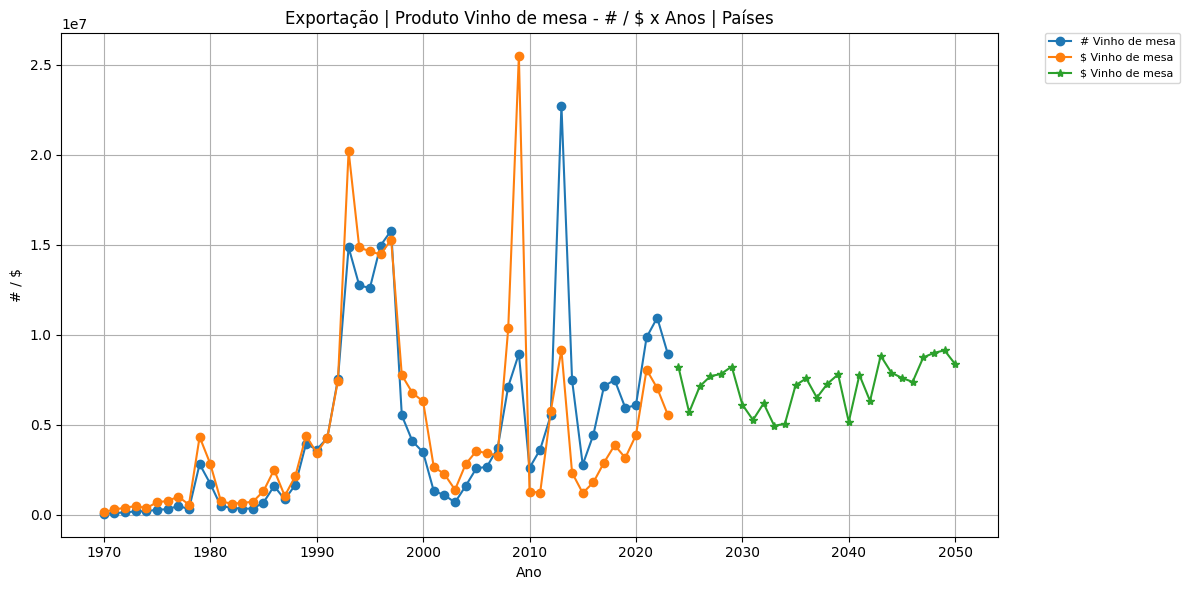

In [105]:

valor_previsto = pipelineExportationAmount.predict(dfPredictExportation)

dfPredictExportation['amount'] = quantidade_prevista.astype(float)

dfPredictExportationTotal = dfPredictExportation.groupby(['product', 'year'])[['quantity', 'amount']].sum().reset_index()
dfPredictExportationTotal.columns = ["product", "year", "total_amount", "total_quantity"]

dfPredictExportation.to_csv('dfPredictExportation.csv')
dfPredictExportationTotal.to_csv('dfPredictExportationConsolidado.csv')
plt.figure(figsize=(12, 6))

for product in dfExportationTotal['product'].unique():
    subset = dfExportationTotal[dfExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_amount'], label=product, marker='o')

for product in dfPredictExportationTotal['product'].unique():
    subset = dfPredictExportationTotal[dfPredictExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_amount'], label=product, marker='*')

plt.title('Valor total de Exportação por produto x ano')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(fontsize='8', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

for product in dfExportationTotal['product'].unique():
    plt.figure(figsize=(12, 6))
    subset = dfExportationTotal[dfExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_quantity'], label=f'# {product}', marker='o')
    plt.plot(subset['year'], subset['total_amount'], label=f'$ {product}', marker='o')
    subset = dfPredictExportationTotal[dfPredictExportationTotal['product'] == product]
    plt.plot(subset['year'], subset['total_amount'], label=f'$ {product}', marker='*')
    
    plt.title(f'Exportação | Produto {product} - # / $ x Anos | Países')
    plt.xlabel('Ano')
    plt.ylabel('# / $')
    plt.legend(fontsize='8', ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
